In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
import matplotlib
pd.options.mode.chained_assignment = None
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# Task 1: Basic analysis
Your first task is to perform a basic clean up and summary analysis of the data. Your objective is to summarise the data in a way that simplifies the subsequent tasks. A region by region estimate of the annual millage of different classes of vehicles is a good starting point. Note, the data is missing from much of the minor roads and you should address this is a sensible way.

The data is downloaded from Road traffic statistics under bulk download, named "Regional traffic: by vehicle type"

In [2]:
df2 = pd.read_csv('region_traffic_by_vehicle_type.csv')
df2 = df2[df2['year'] >= 2000]
df2

,id,year,region_id,ons_code,total_link_length_km,total_link_length_miles,pedal_cycles,two_wheeled_motor_vehicles,cars_and_taxis,buses_and_coaches,lgvs,all_hgvs,all_motor_vehicles
0,1,2015,9,E12000008,47896.8800,29761.74,5.335796e+08,4.938061e+08,44161584807,317222382.3,8045218862,2.450647e+09,55468478734
1,2,2001,7,E12000006,39287.5000,24412.12,3.887977e+08,3.433035e+08,25942676594,296600668.7,3929148042,2.060673e+09,32572402193
2,3,2018,7,E12000006,40003.1251,24856.79,4.558732e+08,3.282085e+08,30647940894,214265260.8,6476405328,2.206569e+09,39873389085
3,4,2014,6,E12000007,14842.8400,9222.91,3.757121e+08,4.202652e+08,15782871411,357612058.6,2838823044,6.466761e+08,20046247854
5,6,2016,11,E12000001,16285.2300,10119.17,9.537544e+07,6.900824e+07,9969855945,138366838.4,1795423974,4.467728e+08,12419427808
...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,302,2001,9,E12000008,47399.1800,29452.48,4.511697e+08,5.384095e+08,42507001875,419231435.5,5610989738,2.554838e+09,51630470816
302,303,2014,2,E12000004,31445.2000,19539.14,2.983650e+08,2.199673e+08,20727376249,191591736.6,3864897703,1.836282e+09,26840114845
304,305,2010,6,E12000007,14819.1000,9208.16,3.634037e+08,4.422842e+08,15348108892,377459057.9,2453383816,6.283220e+08,19249557906
305,306,2005,10,E12000005,32439.2500,20156.82,2.011046e+08,2.413257e+08,23637561216,318963925.7,3764128632,1.953848e+09,29915827962


In [3]:
df2.columns

Index(['id', 'year', 'region_id', 'ons_code', 'total_link_length_km',
       'total_link_length_miles', 'pedal_cycles', 'two_wheeled_motor_vehicles',
       'cars_and_taxis', 'buses_and_coaches', 'lgvs', 'all_hgvs',
       'all_motor_vehicles'],
      dtype='object')

## Checking for Nan in the dataset

In [4]:
df2.isna().sum()

id                            0
year                          0
region_id                     0
ons_code                      0
total_link_length_km          0
total_link_length_miles       0
pedal_cycles                  0
two_wheeled_motor_vehicles    0
cars_and_taxis                0
buses_and_coaches             0
lgvs                          0
all_hgvs                      0
all_motor_vehicles            0
dtype: int64

In [5]:
region_id_values = ['1','2','3','4','5','6','7','8','9','10','11']
region_names = ['South West', 'East Midlands', 'Scotland', 'Wales', 'North West', 'London', 'East of England', 'Yorkshire and The Humber', 'South East', 'West Midlands', 'North East']
df2['region_name'] = df2['region_id'].astype(str).str.strip().replace(dict(zip(region_id_values, region_names)))

In [6]:
df2_annual_region_vehicle = df2.groupby(['year','region_name']).sum()
df2_annual_region_vehicle = df2_annual_region_vehicle[['pedal_cycles','two_wheeled_motor_vehicles','cars_and_taxis','buses_and_coaches','lgvs','all_hgvs','all_motor_vehicles']]
df2_annual_region_vehicle.reset_index(inplace=True)

for col in df2_annual_region_vehicle.columns:
    if col != 'region_name' and col != 'year':
        df2_annual_region_vehicle[f'{col}'] = df2_annual_region_vehicle[f'{col}'] / 1e9

df2_annual_region_vehicle

,year,region_name,pedal_cycles,two_wheeled_motor_vehicles,cars_and_taxis,buses_and_coaches,lgvs,all_hgvs,all_motor_vehicles
0,2000,East Midlands,0.209387,0.204839,18.277014,0.202097,2.637438,1.965540,23.286928
1,2000,East of England,0.382818,0.330687,25.563696,0.295678,3.791534,2.065401,32.046996
2,2000,London,0.281822,0.441184,16.459260,0.318921,2.231814,0.696619,20.147798
3,2000,North East,0.089576,0.073554,9.344539,0.191077,1.209167,0.527882,11.346220
4,2000,North West,0.258356,0.244444,26.432372,0.363608,3.415748,2.118728,32.574900
...,...,...,...,...,...,...,...,...,...
226,2020,South East,0.875716,0.380790,33.732428,0.170067,8.123997,2.304594,44.711876
227,2020,South West,0.499565,0.253280,21.096394,0.139604,5.015562,1.337624,27.842465
228,2020,Wales,0.199823,0.136818,11.503709,0.079696,2.907091,0.656408,15.283721
229,2020,West Midlands,0.318682,0.144163,19.871271,0.092461,4.493435,1.940472,26.541801


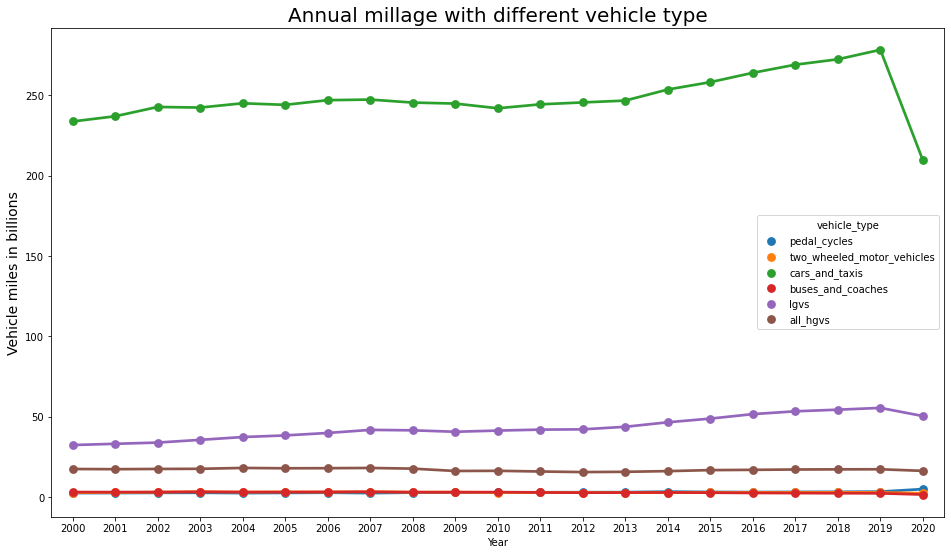

In [71]:
annual_millage_vehicle = df2_annual_region_vehicle.groupby(['year']).sum()
annual_millage_vehicle = annual_millage_vehicle.loc[:,annual_millage_vehicle.columns != "all_motor_vehicles"]
annual_millage_vehicle.reset_index(inplace=True)
annual_millage_vehicle = annual_millage_vehicle.rename(columns = {'index':'year'})

df2_melted = annual_millage_vehicle.melt("year",var_name="vehicle_type")

plt.figure(figsize=(16,9))
ax = sns.pointplot(x='year', y='value', data=df2_melted, hue="vehicle_type")
plt.xlabel('Year')
plt.ylabel('Vehicle miles in billions', fontsize=14)
plt.title('Annual millage with different vehicle type', fontsize=20)
plt.show()

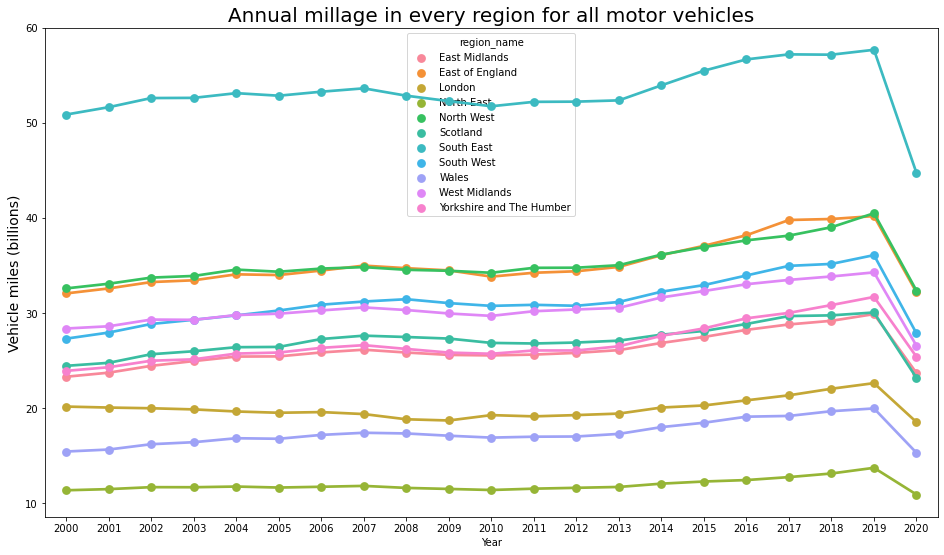

In [8]:
plt.figure(figsize=(16,9))
ax = sns.pointplot(x='year', y='all_motor_vehicles', data=df2_annual_region_vehicle, hue="region_name")
plt.xlabel('Year')
plt.ylabel('Vehicle miles (billions)', fontsize=14)
plt.title('Annual millage in every region for all motor vehicles', fontsize=20)
plt.show()

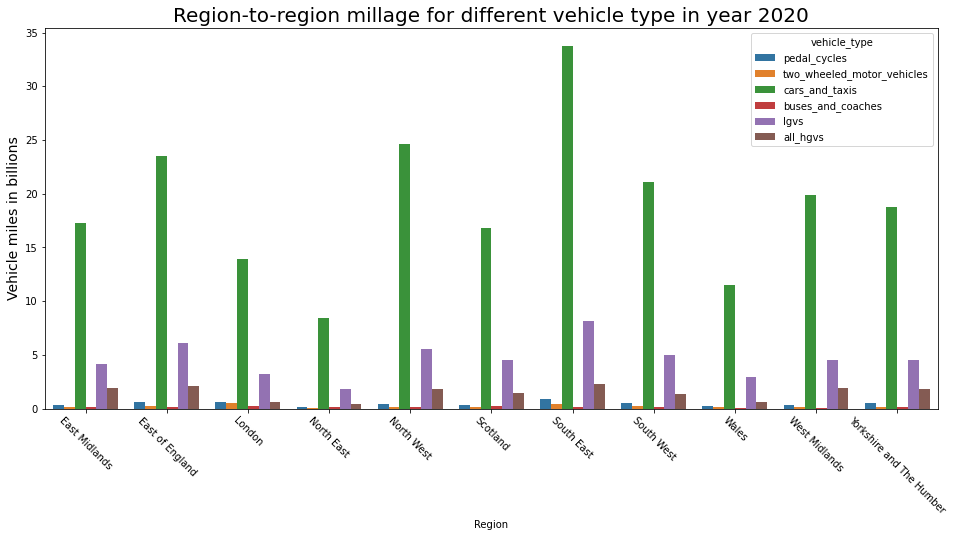

In [30]:
millage_region_vehicle_2020 = df2_annual_region_vehicle.loc[df2_annual_region_vehicle['year'] == 2020]
millage_region_vehicle_2020 = millage_region_vehicle_2020.groupby(['region_name']).sum()
millage_region_vehicle_2020.reset_index(inplace=True)
millage_region_vehicle_2020 = millage_region_vehicle_2020.loc[:,millage_region_vehicle_2020.columns!="all_motor_vehicles"]
millage_region_vehicle_2020 = millage_region_vehicle_2020.loc[:,millage_region_vehicle_2020.columns!="year"]

millage_region_vehicle_2020 = millage_region_vehicle_2020.rename(columns = {'index':'region_name'})
df2_melted = millage_region_vehicle_2020.melt("region_name",var_name="vehicle_type")

plt.figure(figsize=(16, 7))
ax = sns.barplot(x='region_name', y='value', data=df2_melted, hue="vehicle_type")
plt.xlabel('Region')
plt.ylabel('Vehicle miles in billions', fontsize=14)
plt.title('Region-to-region millage for different vehicle type in year 2020', fontsize=20)
plt.xticks(rotation=-45)
plt.show()

## Annual millage for all motor vehicles

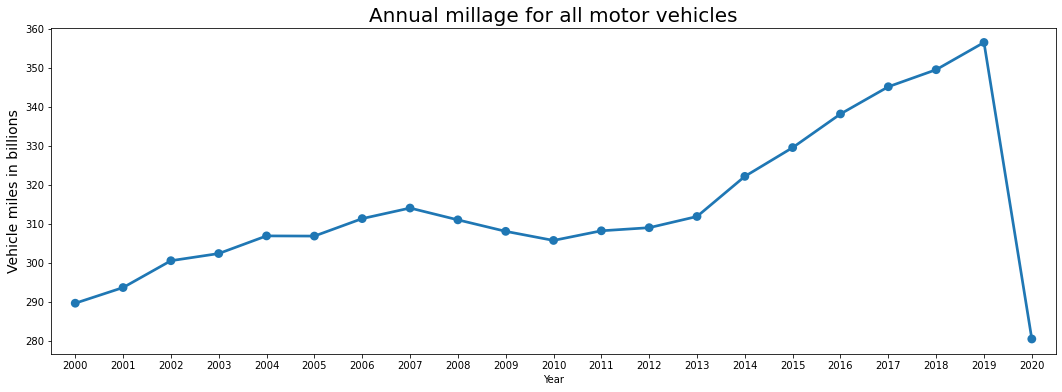

In [10]:
annual_millage = df2_annual_region_vehicle.groupby(['year']).sum()
annual_millage = annual_millage.loc[:,annual_millage.columns=="all_motor_vehicles"]
annual_millage.reset_index(inplace=True)

plt.figure(figsize=(18,6))
ax = sns.pointplot(x='year', y='all_motor_vehicles', data=annual_millage)
plt.xlabel('Year')
plt.ylabel('Vehicle miles in billions', fontsize=14)
plt.title('Annual millage for all motor vehicles', fontsize=20)
plt.show()

Car traffic decreased by 24.7% from 2019 levels. The figure of 209.6 billion vehicle miles (bvm) is the lowest annual estimate for over 25 years.
Van traffic decreased by 9.1% from 2019 to 50.5 bvm. The lowest level for 5 years.
Lorry traffic decreased by 5.7% compared to 2019. At 16.4 bvm, this was the lowest level since 2014.
Pedal cycle traffic (cyclists on public highways, and the paths adjacent to them) was 5.0 bvm, 45.7% above 2019 levels. This is the highest level of cycling on the public highway since the 1960s.

# Task 2: Regression
In this task you should use the summary data to perform a regression analysis to estimate likely changes in traffic over the next thirty years. You should identify any potential risks associated with this analysis that may place limits on how it can be used.
# Forecast

Due to the drop in millage in 2020, the model could not forecast properly. If the data in 2020 is reintroduced back to the forecast, the model would zigzag up and down and be left confused.

In [11]:
annual_millage_00_19 = annual_millage[0:20]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.


Text(0.5, 33.0, 'Year')

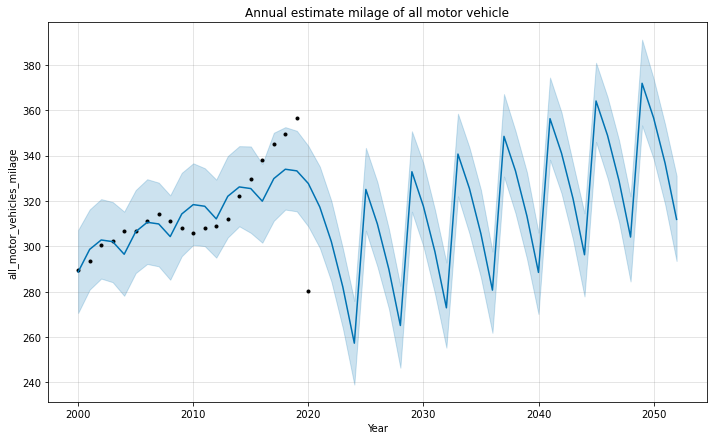

In [32]:
year_est_all_vehicle_2020 = pd.DataFrame(annual_millage)

# year_est_all_vehicle_2020['year'] = year_est_all_vehicle_2020.index
year_est_all_vehicle_2020['year'] = pd.to_datetime(year_est_all_vehicle_2020['year'], format='%Y')
year_est_all_vehicle_2020 = year_est_all_vehicle_2020.rename(columns={'year':'ds', 'all_motor_vehicles':'y'})
fc = year_est_all_vehicle_2020[['ds', 'y']]
# fc['cap'] = 450

m = Prophet(growth = 'linear')
m.fit(fc)
future = m.make_future_dataframe(periods=32, freq ='Y')
# future['cap'] = 450
forecast = m.predict(future)

# Plot
fig = m.plot(forecast)
ax = fig.gca()
ax.set_title('Annual estimate milage of all motor vehicle')
ax.set_ylabel('all_motor_vehicles_milage')
ax.set_xlabel("Year")
# ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))


Therefore, the data in 2020 is treated as an anomaly and remove from the forecast model. 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.


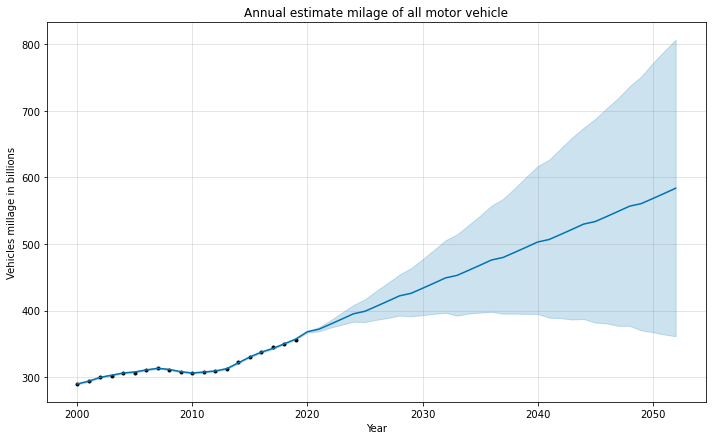

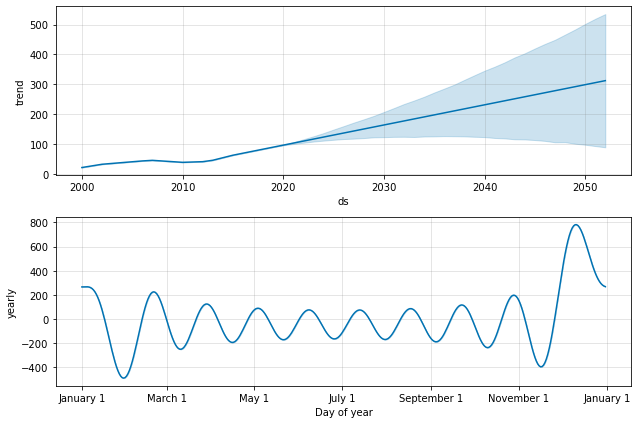

In [51]:
year_est_all_vehicle = pd.DataFrame(annual_millage_00_19)

# year_est_all_vehicle['year'] = year_est_all_vehicle.index
year_est_all_vehicle['year'] = pd.to_datetime(year_est_all_vehicle['year'], format='%Y')
year_est_all_vehicle = year_est_all_vehicle.rename(columns={'year':'ds', 'all_motor_vehicles':'y'})
fc = year_est_all_vehicle[['ds', 'y']]
# fc['cap'] = 900

m = Prophet(growth = 'linear')
m.fit(fc)
future = m.make_future_dataframe(periods=33, freq ='Y')
# future['cap'] = 900
forecast = m.predict(future)

# Plot
fig = m.plot(forecast)
ax = fig.gca()
ax.set_title('Annual estimate milage of all motor vehicle')
ax.set_ylabel('Vehicles millage in billions')
ax.set_xlabel("Year")

fig2 = m.plot_components(forecast)
# ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))


# Task 3: Research
As your objective is to assess the impact of the expected increase in the number and use of electric vehicles, you will need to research published estimates of how much of the UK vehicle fleet will be electric over time. This is unlikely to be a simple regression using historic data, there will be a number of other factors involved. It is these factors and their impact that you need to identify.
Your goal is to estimate the number of electric miles driven each year over the time period and estimate how much power generation will be needed to achieve this. You will need to identify how much additional generation capacity this will require. You should also attempt to locate at least one other independent estimate of this for comparison to your own estimate.

Assuming that as of 2021, only 2% of the total vehicles in the UK are electic based on this website here:
https://heycar.co.uk/blog/electric-cars-statistics-and-projections
and the number of electric vehicle before 2020 can be consider non-existance

Also, based on this 2018 forecast summary, 97% of the vehicles in 2050 is going to be mostly electric:
https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/873929/road-traffic-forecasts-2018-document.pdf

https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/924591/DUKES_2020_MASTER.pdf

https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/840015/DUKES_2019_MASTER_COPY.pdf

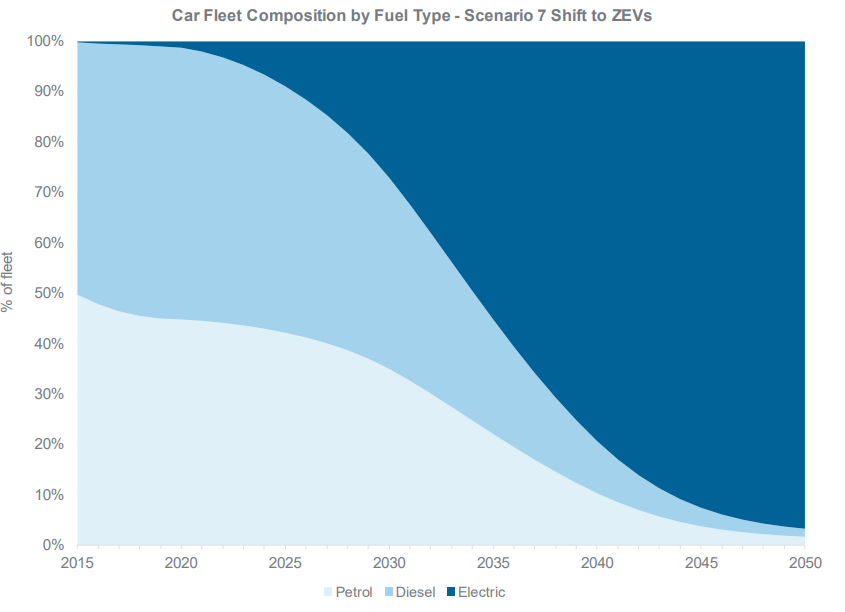

Text(0.5, 0, 'Years')

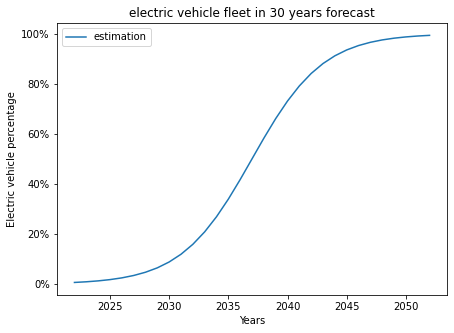

In [52]:
import matplotlib.ticker as mtick

electric_fleet_est = pd.read_csv('electric_vehicle_estimation.csv')
fig = electric_fleet_est.plot(x = 'year', y='estimation', figsize=(7,5))
fig.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
fig.set_title('electric vehicle fleet in 30 years forecast')
fig.set_ylabel('Electric vehicle percentage')
fig.set_xlabel("Years")


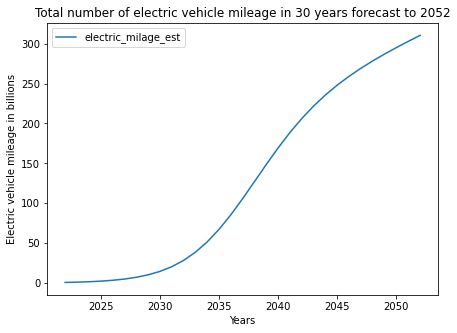

In [53]:
electric_fleet_est['electric_milage_est'] = forecast['trend'][22:].values * electric_fleet_est['estimation']
fig = electric_fleet_est.plot(x='year', y='electric_milage_est', figsize=(7,5))
fig.set_title('Total number of electric vehicle mileage in 30 years forecast to 2052')
fig.set_ylabel('Electric vehicle mileage in billions')
fig.set_xlabel('Years')
fig.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))


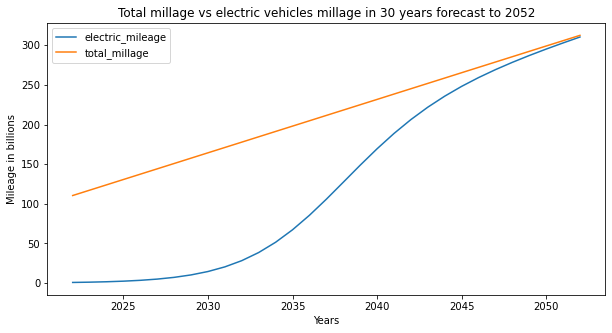

In [54]:
total_v_electric = pd.DataFrame({'electric_mileage': electric_fleet_est['electric_milage_est'] , 'total_millage': forecast['trend'][22:].values, 'year':electric_fleet_est['year']})
fig = total_v_electric.plot(x='year', y=['electric_mileage', 'total_millage'], figsize=(10,5))
fig.set_title('Total millage vs electric vehicles millage in 30 years forecast to 2052')
fig.set_ylabel('Mileage in billions')
fig.set_xlabel('Years')
# fig.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

https://ev-database.uk/cheatsheet/energy-consumption-electric-car

Based on this website, the average energy consumption in the UK is 314 Wh/mi, therefore:

Text(0.5, 0, 'Years')

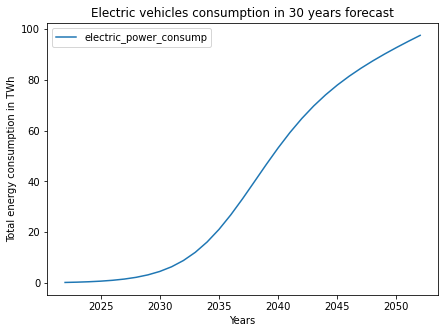

In [61]:
total_v_electric['electric_power_consump'] = total_v_electric['electric_mileage'].values * (314/1e3)
fig = total_v_electric.plot(x='year' , y='electric_power_consump' ,figsize=(7, 5))
fig.set_title('Electric vehicles consumption in 30 years forecast')
fig.set_ylabel('Total energy consumption in TWh')
fig.set_xlabel("Years")
# fig.tick_params(axis="x", labelsize=24)
# fig.tick_params(axis="y", labelsize=24)

Generalizing UK's electrical supply, validated from multiple sources https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/904805/DUKES_2020_Chapter_5.pdf it is around 330TWh annually on average

The UK tries to match the production with the demand at around 5TWh. The additional generation capacity that would be needed for the increasing use of these electric vehicles can be found by comparing the demand with this 5TWh surplus that they had over the years. Assuming that this would also continue for the following years. 

Text(0.5, 0, 'Years')

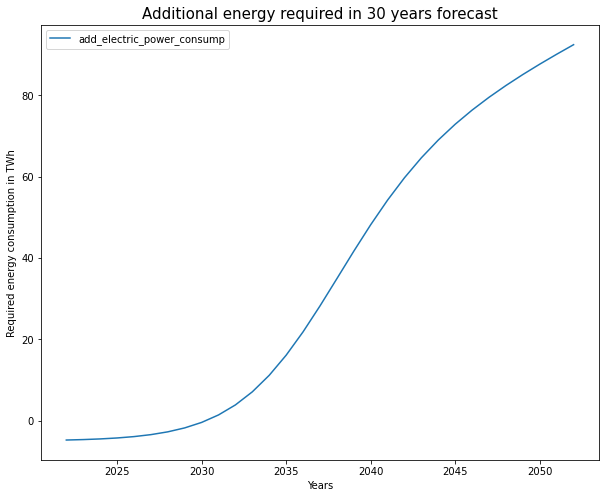

In [18]:
required_energy = 5
total_v_electric['add_electric_power_consump'] = total_v_electric['electric_power_consump'] - required_energy
fig = total_v_electric.plot(x='year' , y='add_electric_power_consump' ,figsize=(10,8))
fig.set_title('Additional energy required in 30 years forecast', size=15)
fig.set_ylabel('Required energy consumption in TWh')
fig.set_xlabel("Years")

# Task 4: Recommendation
Different generation technologies have different £/MWh figures. The Department for business, energy and strategy (BEIS) maintains a regularly updated overview of generation technologies.
https://www.gov.uk/government/collections/energy-generation-cost-projections
Using this and other sources, you should make a recommendation of the amount and type of new generation capacity that will be needed to meet demand at the lowest overall cost. This is in part an optimisation problem. For example, you might need to take into account the impact that the time of day at which charging occurs will have on the mix of generation technologies that are appropriate.


make a recommendation of the amount and type of new generation capacity that will be needed to meet demand at the lowest overall cost.

take into account the impact that the time of day at which charging occurs will have on the mix of generation technologies that are appropriate.


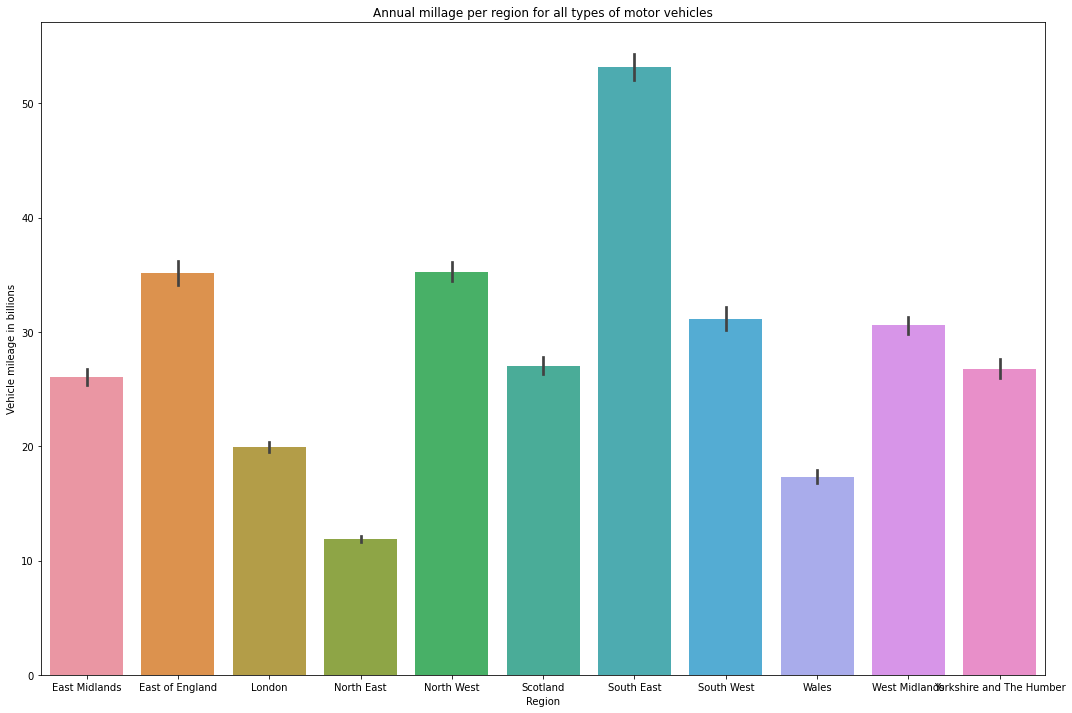

In [19]:
plt.figure(figsize=(18,12))
ax = sns.barplot(x='region_name', y='all_motor_vehicles', data=df2_annual_region_vehicle)
plt.xlabel('Region')
plt.ylabel('Vehicle mileage in billions')
plt.title('Annual millage per region for all types of motor vehicles')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

The additional generation capacity at year 2040 is 103.039

In [20]:
all_avg_millage_region = df2_annual_region_vehicle.groupby(['region_name']).mean()
all_avg_millage_region['millage_ratio'] = (all_avg_millage_region['all_motor_vehicles'] / all_avg_millage_region['all_motor_vehicles'].sum())

all_avg_millage_region['additional_power_2040'] = all_avg_millage_region['millage_ratio'] * 103.039 * 1e6
all_avg_millage_region

,year,pedal_cycles,two_wheeled_motor_vehicles,cars_and_taxis,buses_and_coaches,lgvs,all_hgvs,all_motor_vehicles,millage_ratio,additional_power_2040
region_name,,,,,,,,,,
East Midlands,2010.0,0.249262,0.222522,20.146229,0.192468,3.583855,1.932149,26.077223,0.082957,8.547843e+06
East of England,2010.0,0.448554,0.333753,27.441436,0.262238,5.047703,2.077938,35.163067,0.111861,1.152609e+07
London,2010.0,0.369045,0.477726,15.724341,0.345336,2.718033,0.648315,19.913752,0.063350,6.527521e+06
North East,2010.0,0.092556,0.076988,9.592293,0.169216,1.569163,0.472828,11.880487,0.037794,3.894300e+06
North West,2010.0,0.287769,0.250050,28.121299,0.306080,4.529428,2.025779,35.232635,0.112083,1.154889e+07
Scotland,2010.0,0.187158,0.185452,21.026302,0.367770,3.891017,1.580141,27.050682,0.086054,8.866933e+06
South East,2010.0,0.514483,0.515839,42.767646,0.347432,7.092812,2.460214,53.183942,0.169190,1.743314e+07
South West,2010.0,0.302588,0.373102,24.775563,0.256317,4.315006,1.442601,31.162589,0.099135,1.021477e+07
Wales,2010.0,0.100274,0.150181,13.784065,0.158804,2.498804,0.737214,17.329068,0.055128,5.680289e+06


https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/911817/electricity-generation-cost-report-2020.pdf

This data was recreated from BEIS Levelised Cost Estimates in electricity generation cost report 2020 (Table 4.17) 

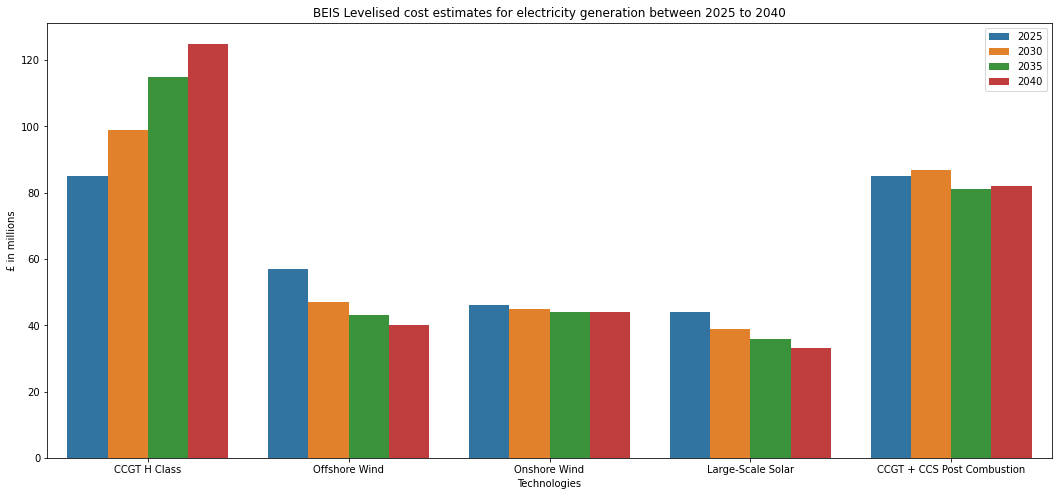

In [62]:
tech_costs = pd.read_csv('BEIS_Levelised_Cost_Estimates_Table4.17.csv')
plt.figure(figsize=(18,8))
ax = sns.barplot(x='technology', y='pound_per_mwh', data=tech_costs, hue="year")
plt.xlabel('Technologies')
plt.ylabel('£ in millions')
plt.title('BEIS Levelised cost estimates for electricity generation between 2025 to 2040')
plt.legend()
plt.show()

Using BEIS projections for the levelised costs for the electricity generating technologies, the lowest cost estimate is Large-Scale Solar, with Offshore Wind and Onshore Wind coming in 2nd and 3rd lowest respectively. Using mostly Large-Scale solar to cover the additional electricity demand would be my recommendation. If consider other factors such as the location, then every region can choose the most suitable energy generating technology, as it would be near-impossible and ridiculous to build an OffShore Wind farm near the London area.

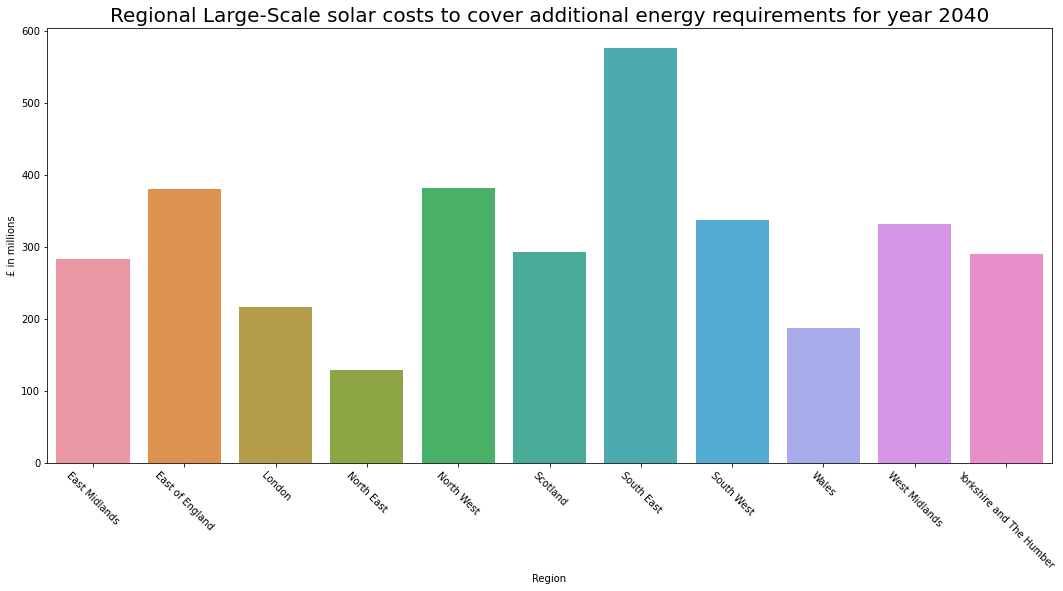

In [64]:
all_avg_millage_region['solar_power_cost_only'] = all_avg_millage_region['additional_power_2040'] * 33 / 1e6

plt.figure(figsize=(18,8))
ax = sns.barplot(x=all_avg_millage_region.index, y='solar_power_cost_only', data=all_avg_millage_region)
plt.xlabel('Region')
plt.xticks(rotation=-45)
plt.ylabel('£ in millions')
plt.title('Regional Large-Scale solar costs to cover additional energy requirements for year 2040', fontsize=20)
plt.show()

## Technology amount
35% OffShore, 25% Onshore, 25% CCGT + CCS, 15% LS Solar

In [23]:
recom_cost = all_avg_millage_region[['additional_power_2040']].copy()

recom_cost['offshore_wind_costs'] = recom_cost['additional_power_2040'] * 40 * 0.35 / 1e6
recom_cost['onshore_wind_costs'] = recom_cost['additional_power_2040'] * 44 * 0.25 / 1e6
recom_cost['CCGT_CCS_costs'] = recom_cost['additional_power_2040'] * 33 * 0.25 / 1e6
recom_cost['solar_costs'] = recom_cost['additional_power_2040'] * 33 * 0.15 / 1e6

recom_cost = recom_cost.loc[:,recom_cost.columns!="additional_power_2040"]
recom_cost.reset_index(inplace=True)

recom_cost = recom_cost.rename(columns = {'index':'region_name'})
df_melted = recom_cost.melt("region_name", var_name="tech_cost")

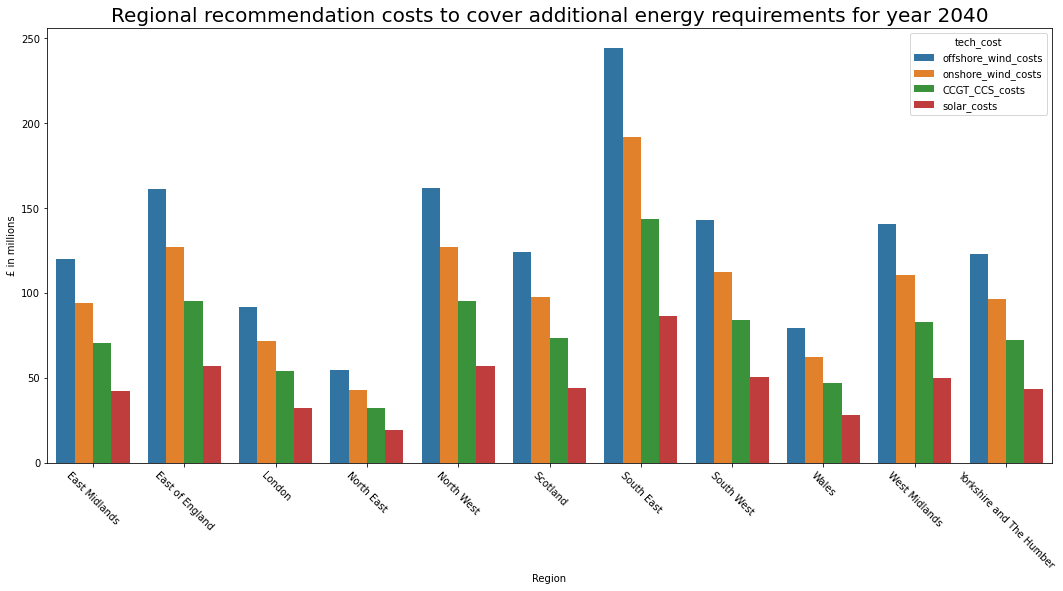

In [65]:
plt.figure(figsize=(18,8))
ax = sns.barplot(x='region_name', y='value', data=df_melted, hue="tech_cost")
plt.xlabel('Region')
plt.ylabel('£ in millions')
plt.title('Regional recommendation costs to cover additional energy requirements for year 2040', fontsize=20)
plt.xticks(rotation=-45)
plt.show()

In [25]:
avg_cost_region = recom_cost.groupby('region_name').sum()
avg_cost_region.mean().sum().round()

358.0